# Fine-Tuning

In [1]:
import os

In [2]:
# Process Dataset
PATH = '../.././dataset/segmentation/'
images = []
labels = []

for filename in os.listdir(PATH):
  labels.append(filename.split('.')[0])
  images.append(os.path.join(PATH, filename))

images[:3], labels[:3]

(['../.././dataset/segmentation/AA4103KN.jpg',
  '../.././dataset/segmentation/AA5045YN.jpg',
  '../.././dataset/segmentation/AA5163XG.jpg'],
 ['AA4103KN', 'AA5045YN', 'AA5163XG'])

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(zip(images, labels),columns=['file_name', 'text'])

df

,file_name,text
0,../.././dataset/segmentation/AA4103KN.jpg,AA4103KN
1,../.././dataset/segmentation/AA5045YN.jpg,AA5045YN
2,../.././dataset/segmentation/AA5163XG.jpg,AA5163XG
3,../.././dataset/segmentation/AA5356WT.jpg,AA5356WT
4,../.././dataset/segmentation/AB4622F0.jpg,AB4622F0
...,...,...
245,../.././dataset/segmentation/KT5498LP.jpg,KT5498LP
246,../.././dataset/segmentation/R5835IF.jpg,R5835IF
247,../.././dataset/segmentation/S4136SI.jpg,S4136SI
248,../.././dataset/segmentation/T6277CH.jpg,T6277CH


In [4]:
# df.head()
path = df['file_name'].iloc[:1].to_string(index=False)
# path='/content/Automatic-License-Plate-Recognition/dataset/segmentation/H5856FZ.jpg'
print(f'{path}')

../.././dataset/segmentation/AA4103KN.jpg


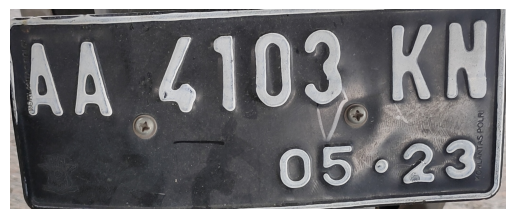

In [5]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
# Split Dataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [7]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [8]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class createDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name and text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # Prepare image (i.e., resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None  # or handle the error in another way

        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids

        # Important: ignore PAD tokens in loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels, dtype=torch.long)  # Ensure dtype consistency
        }

        return encoding


In [9]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch

# Load the model and processor
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare datasets
train_dataset = createDataset(root_dir=PATH, df=train_df, processor=processor)
eval_dataset = createDataset(root_dir=PATH, df=val_df, processor=processor)

# Optionally, check the dataset lengths
print(f"Training dataset size: {len(train_dataset)}")
print(f"Evaluation dataset size: {len(eval_dataset)}")

c:\Users\vanss\.conda\envs\ALPR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_

Training dataset size: 225
Evaluation dataset size: 25


In [10]:
# Setup config trainer

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
# evalulation metrics
import evaluate

cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [12]:
# declare Seq2Seq trainer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainingArguments
# import wandb

# Initialize WandB project
# wandb.init(project="TrOCR_IndonesianLPR")

# Set training arguments with wandb integration
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=2,
    save_steps=1000,
    fp16=True,
    run_name="TrOCR_IndonesianLPR"
)

c:\Users\vanss\.conda\envs\ALPR\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# train model
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
    # add save to hugging face repo or mlflow
)
trainer.train()

trainer.save_model()  # Save locally


c:\Users\vanss\.conda\envs\ALPR\lib\site-packages\transformers\models\trocr\processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
C:\Users\vanss\AppData\Local\Temp\ipykernel_5812\3013669264.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
  0%|          | 0/145 [00:00<?, ?it/s]c:\Users\vanss\.conda\envs\ALPR\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  1%|▏         | 2/145 [00:02<02:24,  1.01s/it]

{'loss': 9.5961, 'grad_norm': inf, 'learning_rate': 5e-05, 'epoch': 0.07}


  3%|▎         | 4/145 [00:08<05:36,  2.38s/it]

{'loss': 7.1542, 'grad_norm': 62.35479736328125, 'learning_rate': 4.931034482758621e-05, 'epoch': 0.14}


  4%|▍         | 6/145 [00:16<07:23,  3.19s/it]

{'loss': 4.0451, 'grad_norm': 40.219573974609375, 'learning_rate': 4.862068965517241e-05, 'epoch': 0.21}


  6%|▌         | 8/145 [00:23<08:01,  3.52s/it]

{'loss': 1.415, 'grad_norm': 19.166940689086914, 'learning_rate': 4.793103448275863e-05, 'epoch': 0.28}


  7%|▋         | 10/145 [00:30<07:49,  3.48s/it]

{'loss': 1.1832, 'grad_norm': 32.10289764404297, 'learning_rate': 4.724137931034483e-05, 'epoch': 0.34}


  8%|▊         | 12/145 [00:37<07:50,  3.54s/it]

{'loss': 0.7937, 'grad_norm': 16.268888473510742, 'learning_rate': 4.655172413793104e-05, 'epoch': 0.41}


 10%|▉         | 14/145 [00:44<07:17,  3.34s/it]

{'loss': 0.8043, 'grad_norm': 12.966456413269043, 'learning_rate': 4.586206896551724e-05, 'epoch': 0.48}


 11%|█         | 16/145 [00:51<07:49,  3.64s/it]

{'loss': 1.755, 'grad_norm': nan, 'learning_rate': 4.551724137931035e-05, 'epoch': 0.55}


 12%|█▏        | 18/145 [00:58<07:17,  3.45s/it]

{'loss': 0.8696, 'grad_norm': 17.903242111206055, 'learning_rate': 4.482758620689655e-05, 'epoch': 0.62}


 14%|█▍        | 20/145 [01:05<06:37,  3.18s/it]

{'loss': 0.863, 'grad_norm': 18.506938934326172, 'learning_rate': 4.413793103448276e-05, 'epoch': 0.69}


 15%|█▌        | 22/145 [01:12<07:29,  3.66s/it]

{'loss': 1.2085, 'grad_norm': 18.54834747314453, 'learning_rate': 4.344827586206897e-05, 'epoch': 0.76}


 17%|█▋        | 24/145 [01:19<07:06,  3.52s/it]

{'loss': 1.1521, 'grad_norm': 25.582496643066406, 'learning_rate': 4.275862068965518e-05, 'epoch': 0.83}


 18%|█▊        | 26/145 [01:26<07:08,  3.60s/it]

{'loss': 0.8621, 'grad_norm': 57.65006637573242, 'learning_rate': 4.2068965517241385e-05, 'epoch': 0.9}


 19%|█▉        | 28/145 [01:34<06:39,  3.41s/it]

{'loss': 0.868, 'grad_norm': 24.494760513305664, 'learning_rate': 4.1379310344827587e-05, 'epoch': 0.97}


 21%|██        | 30/145 [01:39<06:03,  3.16s/it]

{'loss': 0.9204, 'grad_norm': 22.72412872314453, 'learning_rate': 4.0689655172413795e-05, 'epoch': 1.03}


 22%|██▏       | 32/145 [01:46<06:17,  3.34s/it]

{'loss': 0.6683, 'grad_norm': 19.101057052612305, 'learning_rate': 4e-05, 'epoch': 1.1}


 23%|██▎       | 34/145 [01:53<06:15,  3.38s/it]

{'loss': 0.395, 'grad_norm': 14.019179344177246, 'learning_rate': 3.931034482758621e-05, 'epoch': 1.17}


 25%|██▍       | 36/145 [01:59<06:05,  3.36s/it]

{'loss': 0.937, 'grad_norm': 38.37266540527344, 'learning_rate': 3.862068965517241e-05, 'epoch': 1.24}


 26%|██▌       | 38/145 [02:07<05:57,  3.34s/it]

{'loss': 0.9152, 'grad_norm': 25.260684967041016, 'learning_rate': 3.793103448275862e-05, 'epoch': 1.31}


 28%|██▊       | 40/145 [02:13<06:00,  3.44s/it]

{'loss': 0.7072, 'grad_norm': 16.317214965820312, 'learning_rate': 3.724137931034483e-05, 'epoch': 1.38}


 29%|██▉       | 42/145 [02:20<05:58,  3.48s/it]

{'loss': 0.8094, 'grad_norm': 19.147192001342773, 'learning_rate': 3.655172413793104e-05, 'epoch': 1.45}


 30%|███       | 44/145 [02:27<05:33,  3.31s/it]

{'loss': 0.664, 'grad_norm': 13.700654029846191, 'learning_rate': 3.586206896551724e-05, 'epoch': 1.52}


 32%|███▏      | 46/145 [02:33<05:34,  3.38s/it]

{'loss': 0.5483, 'grad_norm': 50.383113861083984, 'learning_rate': 3.517241379310345e-05, 'epoch': 1.59}


 33%|███▎      | 48/145 [02:41<05:24,  3.35s/it]

{'loss': 0.6952, 'grad_norm': 21.994300842285156, 'learning_rate': 3.4482758620689657e-05, 'epoch': 1.66}


 34%|███▍      | 50/145 [02:48<05:41,  3.59s/it]

{'loss': 0.6265, 'grad_norm': 19.688730239868164, 'learning_rate': 3.3793103448275865e-05, 'epoch': 1.72}


 36%|███▌      | 52/145 [02:56<05:30,  3.55s/it]

{'loss': 0.7897, 'grad_norm': 21.365638732910156, 'learning_rate': 3.310344827586207e-05, 'epoch': 1.79}


 37%|███▋      | 54/145 [03:03<05:29,  3.62s/it]

{'loss': 0.6835, 'grad_norm': 104.47227478027344, 'learning_rate': 3.2413793103448275e-05, 'epoch': 1.86}


 39%|███▊      | 56/145 [03:09<05:15,  3.54s/it]

{'loss': 0.4932, 'grad_norm': 8.468111991882324, 'learning_rate': 3.172413793103448e-05, 'epoch': 1.93}


 40%|████      | 58/145 [03:14<03:48,  2.62s/it]

{'loss': 0.5181, 'grad_norm': 12.350384712219238, 'learning_rate': 3.103448275862069e-05, 'epoch': 2.0}


 41%|████▏     | 60/145 [03:21<04:16,  3.02s/it]

{'loss': 0.3642, 'grad_norm': 8.39349365234375, 'learning_rate': 3.0344827586206897e-05, 'epoch': 2.07}


 43%|████▎     | 62/145 [03:28<04:46,  3.46s/it]

{'loss': 0.3082, 'grad_norm': 7.510200023651123, 'learning_rate': 2.96551724137931e-05, 'epoch': 2.14}


 44%|████▍     | 64/145 [03:35<04:44,  3.51s/it]

{'loss': 0.4581, 'grad_norm': 15.039950370788574, 'learning_rate': 2.8965517241379313e-05, 'epoch': 2.21}


 46%|████▌     | 66/145 [03:42<04:25,  3.36s/it]

{'loss': 0.4924, 'grad_norm': 34.14384841918945, 'learning_rate': 2.8275862068965518e-05, 'epoch': 2.28}


 47%|████▋     | 68/145 [03:49<04:10,  3.25s/it]

{'loss': 0.5659, 'grad_norm': 15.705906867980957, 'learning_rate': 2.7586206896551727e-05, 'epoch': 2.34}


 48%|████▊     | 70/145 [03:56<04:17,  3.43s/it]

{'loss': 0.4407, 'grad_norm': 10.014962196350098, 'learning_rate': 2.689655172413793e-05, 'epoch': 2.41}


 50%|████▉     | 72/145 [04:03<04:10,  3.43s/it]

{'loss': 0.3574, 'grad_norm': 4.548661708831787, 'learning_rate': 2.620689655172414e-05, 'epoch': 2.48}


 51%|█████     | 74/145 [04:10<04:07,  3.49s/it]

{'loss': 0.672, 'grad_norm': 9.31468677520752, 'learning_rate': 2.551724137931035e-05, 'epoch': 2.55}


 52%|█████▏    | 76/145 [04:17<04:07,  3.59s/it]

{'loss': 0.3814, 'grad_norm': 6.753380298614502, 'learning_rate': 2.4827586206896553e-05, 'epoch': 2.62}


 54%|█████▍    | 78/145 [04:24<03:53,  3.49s/it]

{'loss': 0.3282, 'grad_norm': 11.880284309387207, 'learning_rate': 2.413793103448276e-05, 'epoch': 2.69}


 55%|█████▌    | 80/145 [04:31<03:54,  3.61s/it]

{'loss': 0.5599, 'grad_norm': 14.401586532592773, 'learning_rate': 2.3448275862068967e-05, 'epoch': 2.76}


 57%|█████▋    | 82/145 [04:39<03:41,  3.52s/it]

{'loss': 0.4572, 'grad_norm': 8.296394348144531, 'learning_rate': 2.2758620689655175e-05, 'epoch': 2.83}


 58%|█████▊    | 84/145 [04:45<03:31,  3.46s/it]

{'loss': 0.4036, 'grad_norm': 15.175908088684082, 'learning_rate': 2.206896551724138e-05, 'epoch': 2.9}


 59%|█████▉    | 86/145 [04:52<03:21,  3.41s/it]

{'loss': 0.331, 'grad_norm': 7.524711608886719, 'learning_rate': 2.137931034482759e-05, 'epoch': 2.97}


 61%|██████    | 88/145 [04:57<02:34,  2.70s/it]

{'loss': 0.2212, 'grad_norm': 3.3107030391693115, 'learning_rate': 2.0689655172413793e-05, 'epoch': 3.03}


 62%|██████▏   | 90/145 [05:04<03:10,  3.46s/it]

{'loss': 0.2736, 'grad_norm': 9.592033386230469, 'learning_rate': 2e-05, 'epoch': 3.1}


 63%|██████▎   | 92/145 [05:11<03:04,  3.48s/it]

{'loss': 0.3049, 'grad_norm': 11.0676851272583, 'learning_rate': 1.9310344827586207e-05, 'epoch': 3.17}


 65%|██████▍   | 94/145 [05:18<02:51,  3.36s/it]

{'loss': 0.2896, 'grad_norm': 6.9821343421936035, 'learning_rate': 1.8620689655172415e-05, 'epoch': 3.24}


 66%|██████▌   | 96/145 [05:24<02:30,  3.08s/it]

{'loss': 0.292, 'grad_norm': 5.041504859924316, 'learning_rate': 1.793103448275862e-05, 'epoch': 3.31}


 68%|██████▊   | 98/145 [05:29<02:18,  2.94s/it]

{'loss': 0.3194, 'grad_norm': 5.616158962249756, 'learning_rate': 1.7241379310344828e-05, 'epoch': 3.38}


 69%|██████▉   | 100/145 [05:36<02:15,  3.01s/it]

{'loss': 0.2901, 'grad_norm': 7.344367027282715, 'learning_rate': 1.6551724137931037e-05, 'epoch': 3.45}


 70%|███████   | 102/145 [05:43<02:23,  3.33s/it]

{'loss': 0.2792, 'grad_norm': 3.8372161388397217, 'learning_rate': 1.586206896551724e-05, 'epoch': 3.52}


 72%|███████▏  | 104/145 [05:50<02:18,  3.38s/it]

{'loss': 0.2547, 'grad_norm': 12.477903366088867, 'learning_rate': 1.5172413793103448e-05, 'epoch': 3.59}


 73%|███████▎  | 106/145 [05:59<02:34,  3.97s/it]

{'loss': 0.4255, 'grad_norm': 4.7534284591674805, 'learning_rate': 1.4482758620689657e-05, 'epoch': 3.66}


 74%|███████▍  | 108/145 [06:08<02:30,  4.07s/it]

{'loss': 0.4736, 'grad_norm': 24.51722526550293, 'learning_rate': 1.3793103448275863e-05, 'epoch': 3.72}


 76%|███████▌  | 110/145 [06:16<02:29,  4.27s/it]

{'loss': 0.2681, 'grad_norm': 6.556183815002441, 'learning_rate': 1.310344827586207e-05, 'epoch': 3.79}


 77%|███████▋  | 112/145 [06:26<02:26,  4.42s/it]

{'loss': 0.3166, 'grad_norm': 4.2503228187561035, 'learning_rate': 1.2413793103448277e-05, 'epoch': 3.86}


 79%|███████▊  | 114/145 [06:36<02:26,  4.74s/it]

{'loss': 0.2648, 'grad_norm': 4.387001991271973, 'learning_rate': 1.1724137931034483e-05, 'epoch': 3.93}


 80%|████████  | 116/145 [06:42<01:50,  3.81s/it]

{'loss': 0.264, 'grad_norm': 6.264632225036621, 'learning_rate': 1.103448275862069e-05, 'epoch': 4.0}


 81%|████████▏ | 118/145 [06:52<01:51,  4.12s/it]

{'loss': 0.2758, 'grad_norm': 6.553542137145996, 'learning_rate': 1.0344827586206897e-05, 'epoch': 4.07}


 83%|████████▎ | 120/145 [07:02<01:50,  4.40s/it]

{'loss': 0.2947, 'grad_norm': 3.6639609336853027, 'learning_rate': 9.655172413793103e-06, 'epoch': 4.14}


 84%|████████▍ | 122/145 [07:12<01:51,  4.83s/it]

{'loss': 0.2427, 'grad_norm': 3.1570565700531006, 'learning_rate': 8.96551724137931e-06, 'epoch': 4.21}


 86%|████████▌ | 124/145 [07:21<01:42,  4.89s/it]

{'loss': 0.2244, 'grad_norm': 2.2681355476379395, 'learning_rate': 8.275862068965518e-06, 'epoch': 4.28}


 87%|████████▋ | 126/145 [07:30<01:27,  4.59s/it]

{'loss': 0.2527, 'grad_norm': 3.8345563411712646, 'learning_rate': 7.586206896551724e-06, 'epoch': 4.34}


 88%|████████▊ | 128/145 [07:39<01:18,  4.64s/it]

{'loss': 0.2612, 'grad_norm': 4.108908176422119, 'learning_rate': 6.896551724137932e-06, 'epoch': 4.41}


 90%|████████▉ | 130/145 [07:49<01:10,  4.69s/it]

{'loss': 0.2348, 'grad_norm': 3.7515347003936768, 'learning_rate': 6.206896551724138e-06, 'epoch': 4.48}


 91%|█████████ | 132/145 [07:59<01:01,  4.72s/it]

{'loss': 0.2207, 'grad_norm': 1.983867883682251, 'learning_rate': 5.517241379310345e-06, 'epoch': 4.55}


 92%|█████████▏| 134/145 [08:10<00:56,  5.14s/it]

{'loss': 0.2712, 'grad_norm': 2.3251218795776367, 'learning_rate': 4.827586206896552e-06, 'epoch': 4.62}


 94%|█████████▍| 136/145 [08:20<00:47,  5.27s/it]

{'loss': 0.2427, 'grad_norm': 2.6828789710998535, 'learning_rate': 4.137931034482759e-06, 'epoch': 4.69}


 95%|█████████▌| 138/145 [08:30<00:34,  4.99s/it]

{'loss': 0.2741, 'grad_norm': 5.0318708419799805, 'learning_rate': 3.448275862068966e-06, 'epoch': 4.76}


 97%|█████████▋| 140/145 [08:41<00:25,  5.17s/it]

{'loss': 0.2496, 'grad_norm': 3.615959644317627, 'learning_rate': 2.7586206896551725e-06, 'epoch': 4.83}


 98%|█████████▊| 142/145 [08:50<00:14,  4.83s/it]

{'loss': 0.2732, 'grad_norm': 2.165581464767456, 'learning_rate': 2.0689655172413796e-06, 'epoch': 4.9}


 99%|█████████▉| 144/145 [09:01<00:05,  5.39s/it]

{'loss': 0.2325, 'grad_norm': 3.1326098442077637, 'learning_rate': 1.3793103448275862e-06, 'epoch': 4.97}


100%|██████████| 145/145 [09:03<00:00,  4.22s/it]c:\Users\vanss\.conda\envs\ALPR\lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
100%|██████████| 145/145 [11:01<00:00,  4.57s/it]


{'train_runtime': 662.4073, 'train_samples_per_second': 1.698, 'train_steps_per_second': 0.219, 'train_loss': 0.7895227917309465, 'epoch': 5.0}


# Hugging Face

In [ ]:
# from huggingface_hub import login

# Provide your Hugging Face API token directly (this can also be stored as an environment variable)
# login()

In [15]:
# trainer.push_to_hub(commit_message="Training complete, model saved.")  # Push to Hugging Face Hub

# Load Model

In [16]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch
from PIL import Image

# Load the fine-tuned model
model_path = "./results/checkpoint-145"
model = VisionEncoderDecoderModel.from_pretrained(model_path)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

# Evaluation

In [17]:
# Process Dataset
PATH = '../.././dataset/test/'
images = []
labels = []

for filename in os.listdir(PATH):
  labels.append(filename.split('.')[0])
  images.append(os.path.join(PATH, filename))

labels[:3], images[:3]

(['B8837NR', 'B9736JFK', 'E2118ST'],
 ['../.././dataset/test/B8837NR.jpg',
  '../.././dataset/test/B9736JFK.jpeg',
  '../.././dataset/test/E2118ST.jpg'])

In [18]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def OCR(image_path, model=model, processor=processor, device=device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare image for the model
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Move the input to the appropriate device (CPU/GPU)
    pixel_values = pixel_values.to(device)

    # Generate prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        generated_ids = model.generate(pixel_values)

    # Decode the predicted IDs to get the text
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # print(f"Predicted Text: {predicted_text}")

    # Add the label to the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()  # Load a default font, you can customize this

    # Define the position for the text label
    text_position = (10, 10)

    # Draw the predicted text on the image
    draw.text(text_position, predicted_text, font=font, fill=(255, 0, 0))  # Red text

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

    return predicted_text

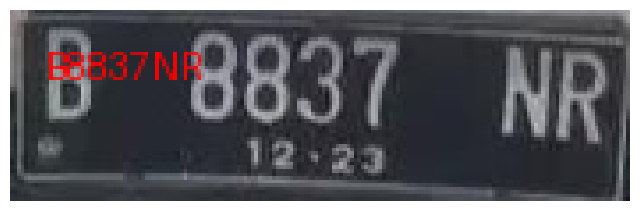

'B8837NR'

In [19]:
OCR('../../dataset/test/B8837NR.jpg')

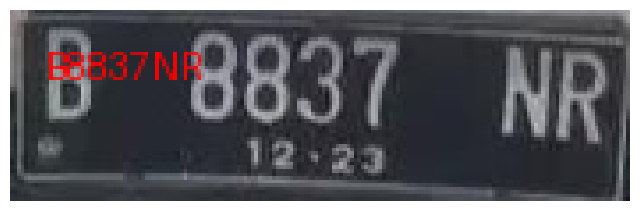

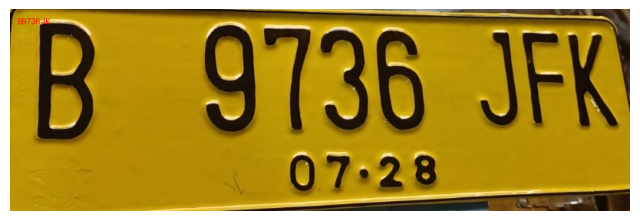

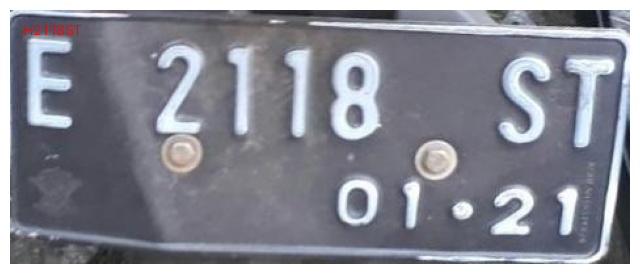

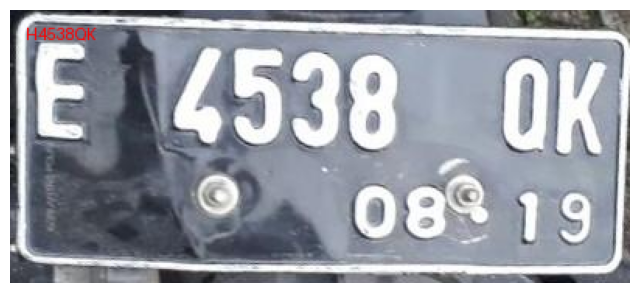

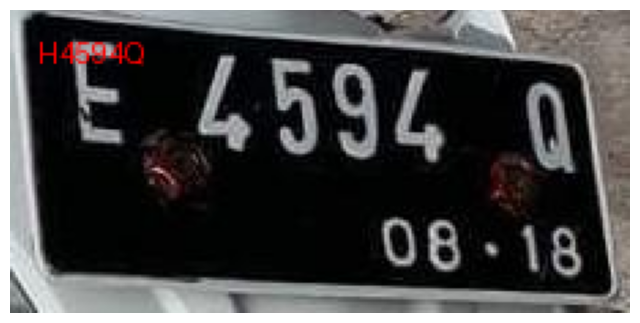

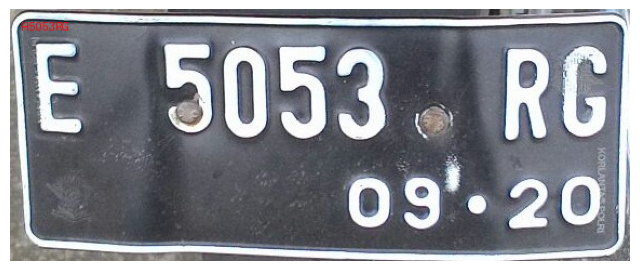

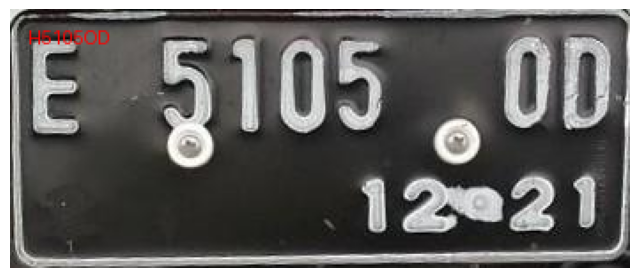

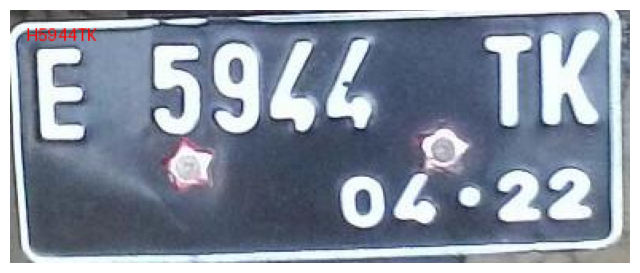

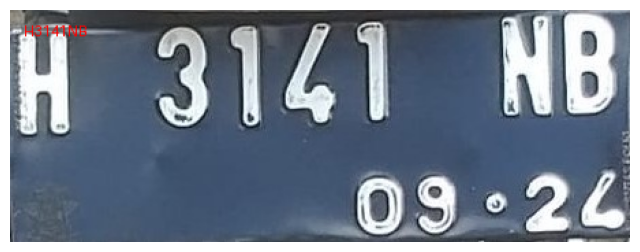

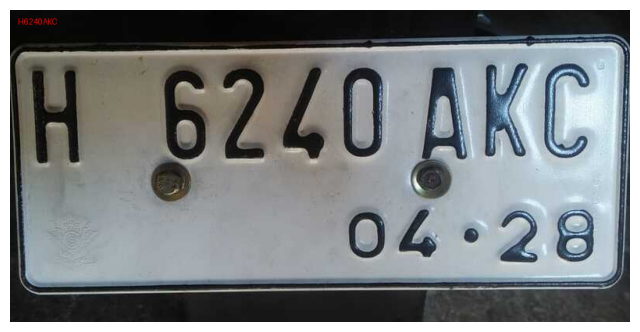

10

In [20]:
result = []
for i in images:
  result.append(OCR(i))
len(result)

In [21]:
import evaluate
wer = evaluate.load('wer')
cer = evaluate.load('cer')

In [22]:
word_accuracy = wer.compute(references=labels, predictions=result)
character_accuracy = cer.compute(references=labels, predictions=result)

print(f'wer: {word_accuracy}, cer: {character_accuracy}')

wer: 0.7, cer: 0.09859154929577464


In [23]:
for i,x in enumerate(zip(result, labels)):
  print(i,x)

0 ('B8837NR', 'B8837NR')
1 ('B9736JK', 'B9736JFK')
2 ('H2118ST', 'E2118ST')
3 ('H4538QK', 'E4538QK')
4 ('H4594Q', 'E4594Q')
5 ('H5053RG', 'E5053RG')
6 ('H5105OD', 'E5105OD')
7 ('H5944TK', 'E5944TK')
8 ('H3141NB', 'H3141NB')
9 ('H6240AKC', 'H6240AKC')
